# The Many Variables & The Spurious Waffles

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
def standardize(col):
    return (col - col.mean())/col.std()

## 5.1 Spurious association

#### Code 5.1

In [3]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
d['Divorce_s'] = (d.Divorce - d.Divorce.mean()) / d.Divorce.std()

#### Code 5.2

In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

#### Code 5.3

In [5]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=0, sd=0.2)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    # sigma = pm.Uniform('sigma', lower=0, upper=1)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1330.94draws/s]


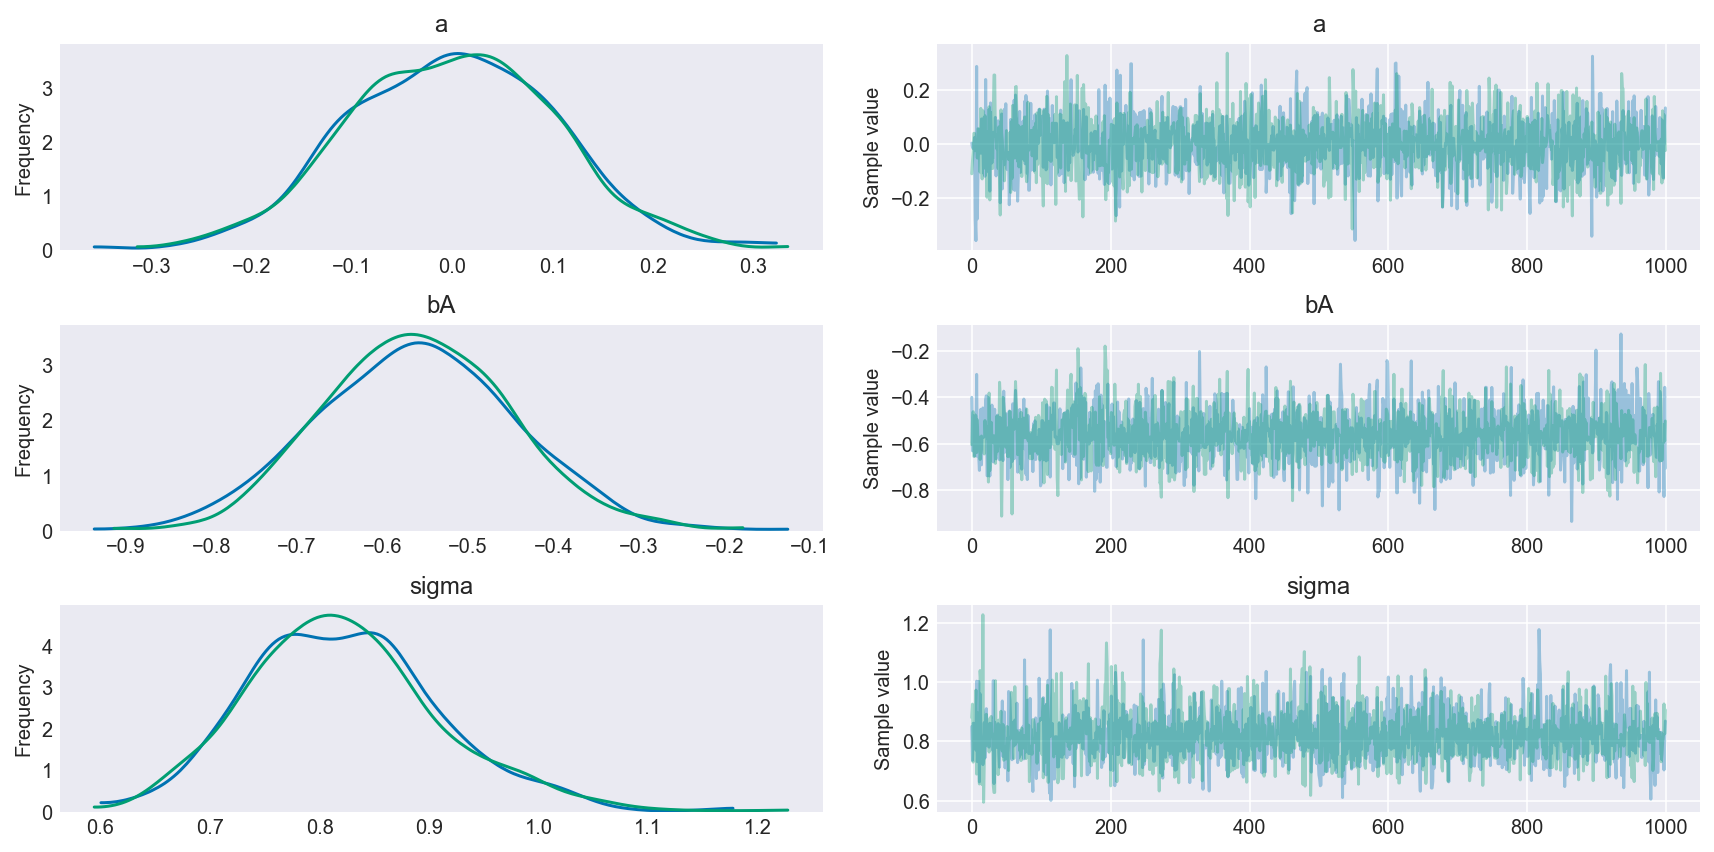

In [6]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.4

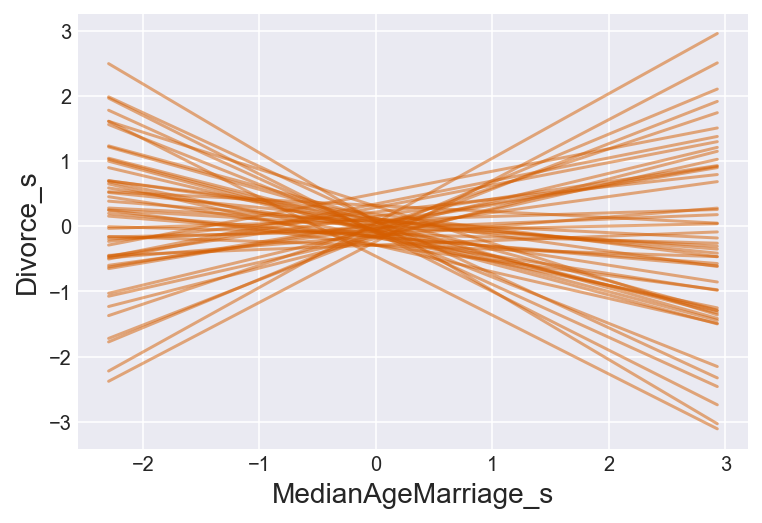

In [7]:
N = 50
a = stats.norm.rvs(loc=0, scale=0.2, size=N)
bA = stats.norm.rvs(loc=0, scale=0.5, size=N)

idx = np.argsort(d.MedianAgeMarriage_s)

for (ai, bAi) in zip(a, bA):
    divorcePred = (ai + bAi * d['MedianAgeMarriage_s'][idx])
    plt.plot(d.MedianAgeMarriage_s[idx], divorcePred , 'C2-', alpha=0.5)
plt.xlabel("MedianAgeMarriage_s", fontsize=14)
plt.ylabel("Divorce_s", fontsize=14);

#### Code 5.5

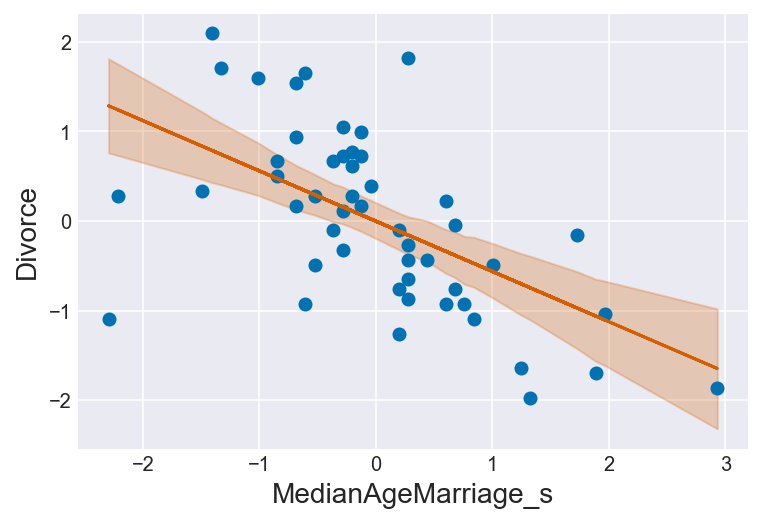

In [8]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce_s, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage_s', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

#### Code 5.6

In [9]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [10]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bM', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 811.60draws/s] 


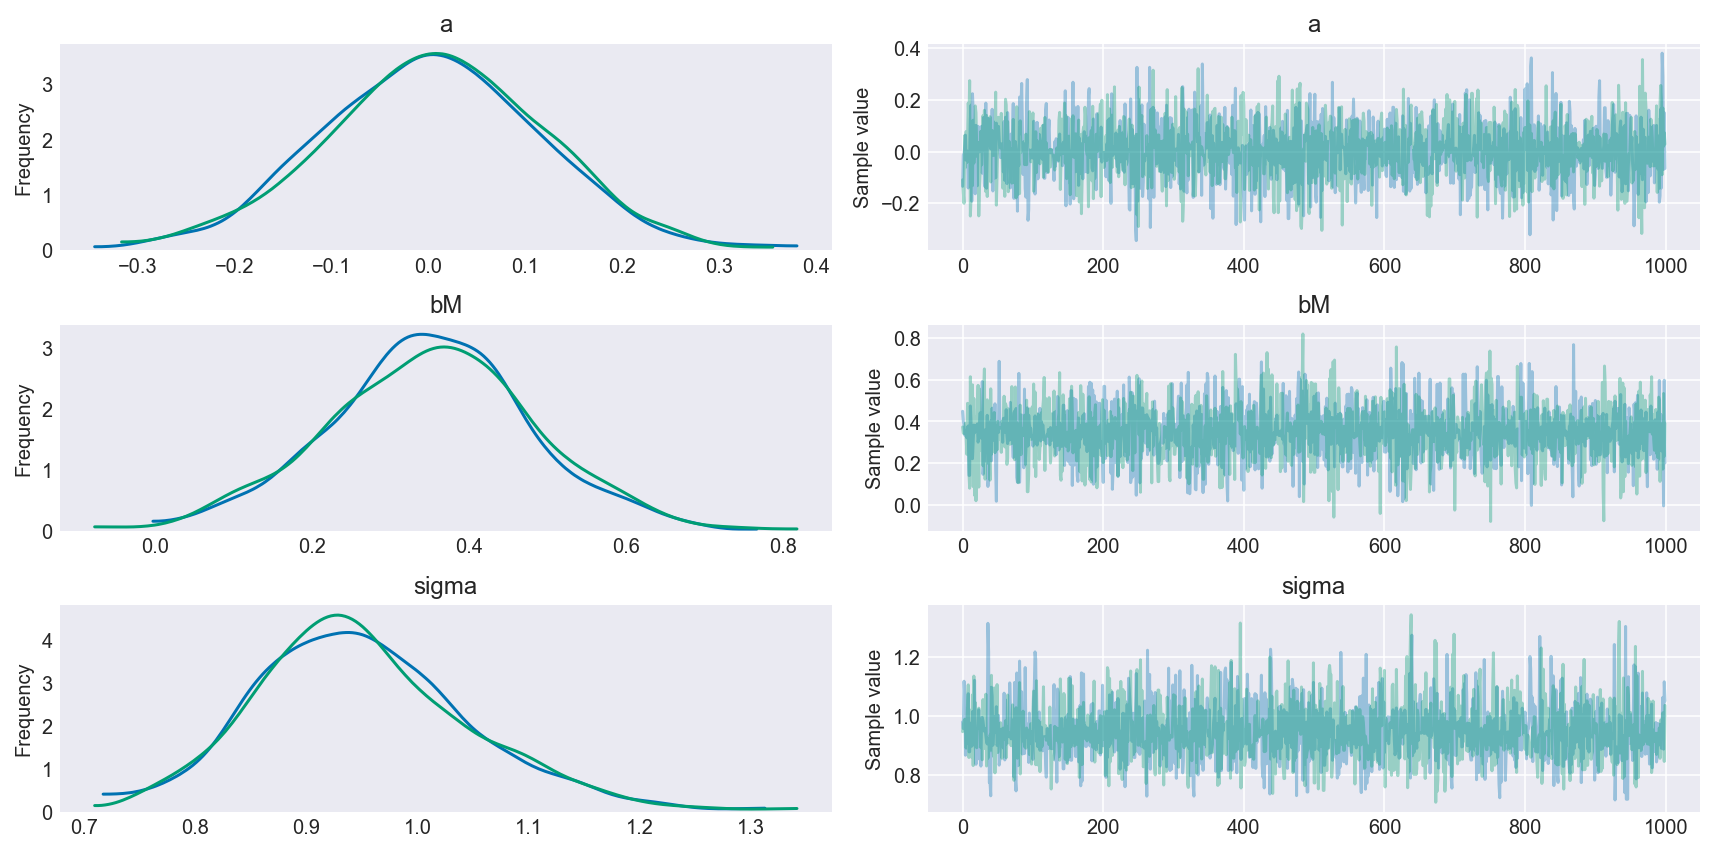

In [11]:
pm.traceplot(trace_5_2, ['a', 'bM','sigma']);

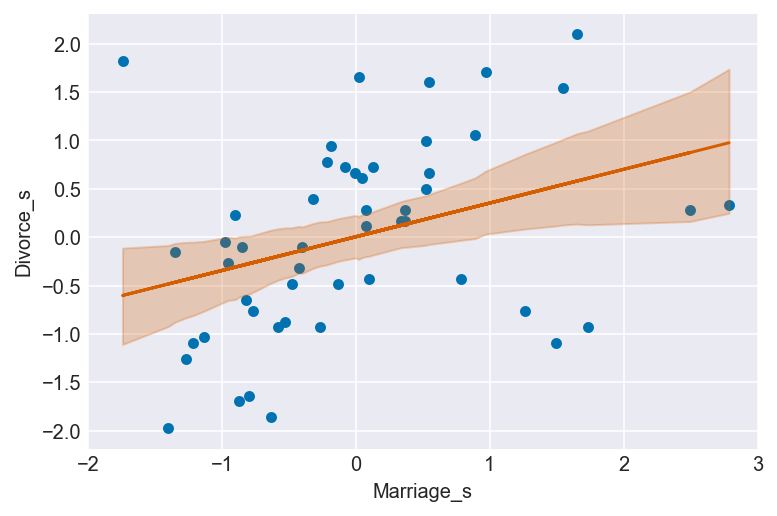

In [12]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce_s', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx],
                 color='C2', alpha=0.25);

### 5.1.1. Think before you regress

#### Code 5.7

In [13]:
# TODO: Find a DAG drawing package for python

### 5.1.2. Multiple regression notation

### 5.1.3. Approximating the posterior

#### Code 5.8

In [14]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bM', mu=0, sd=0.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * d.Marriage_s + bA * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 624.41draws/s] 


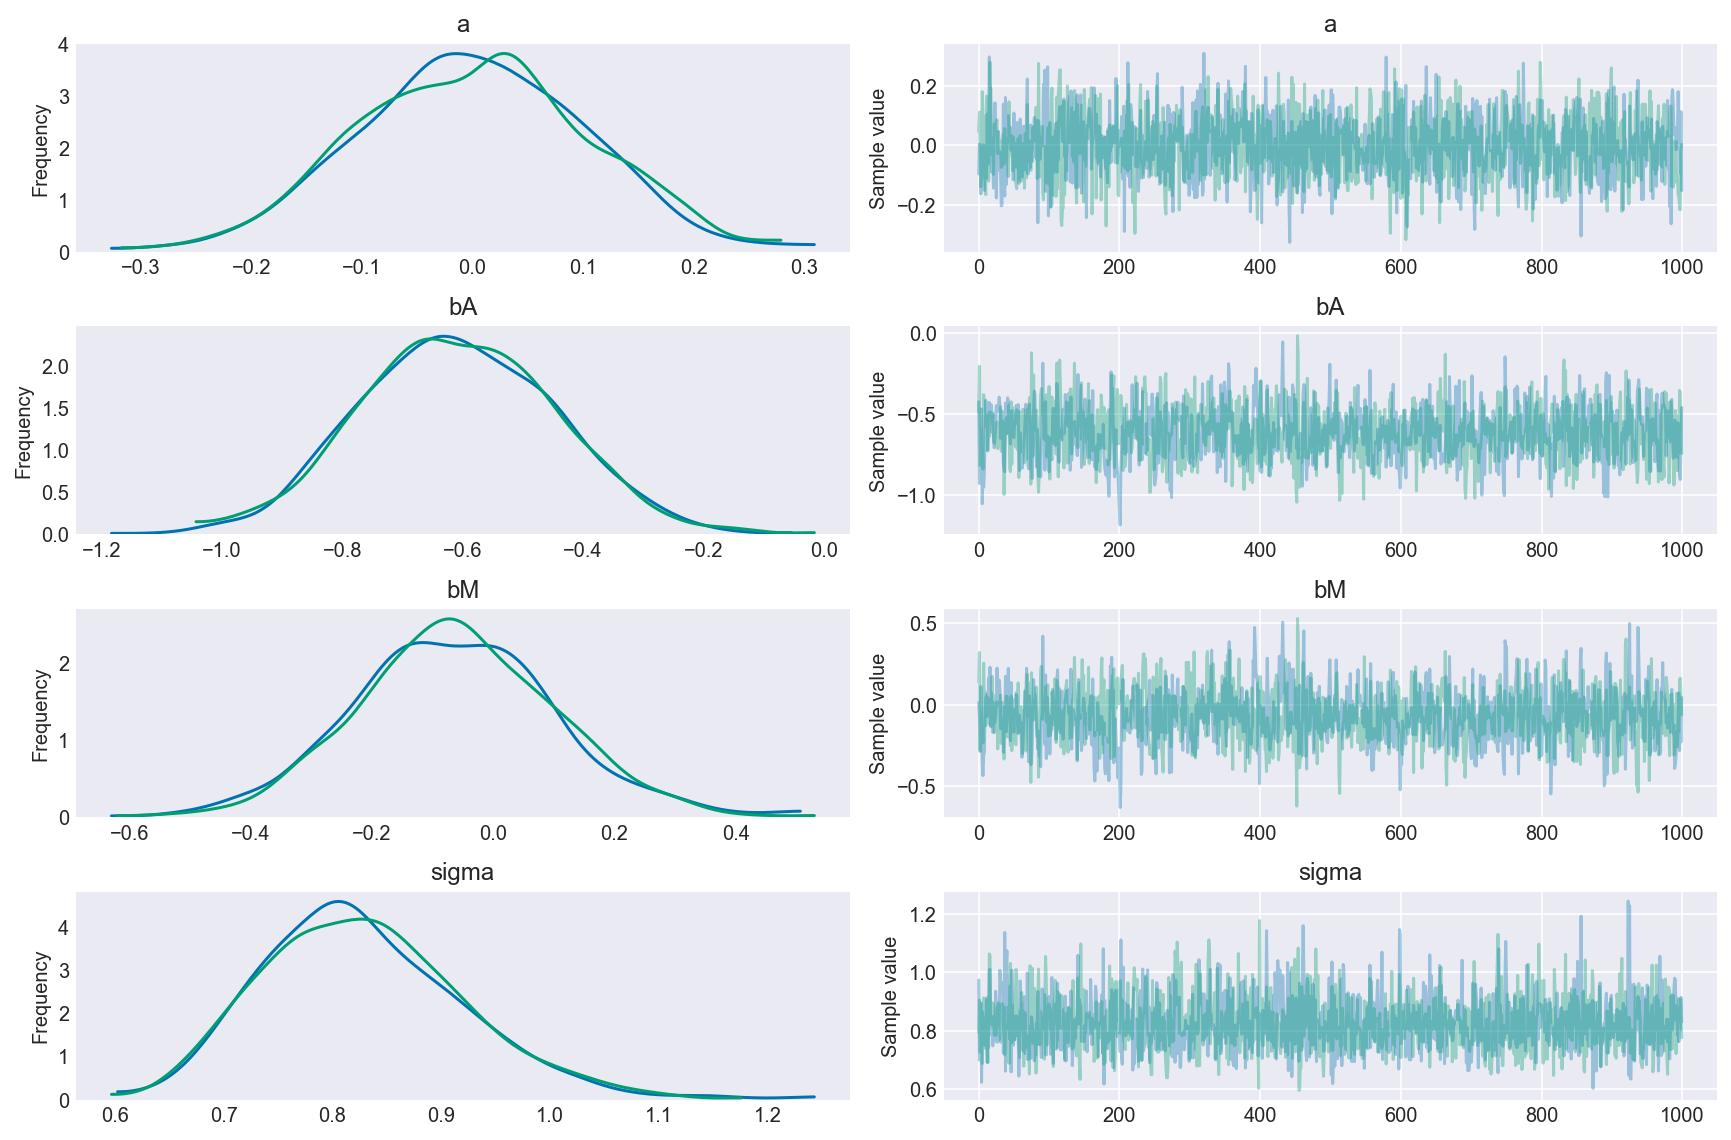

In [15]:
varnames = ['a', 'bA', 'bM', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [16]:
pm.summary(trace_5_3, varnames, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a     -0.00  0.10       0.0    -0.16      0.17  1788.04   1.0
bA    -0.61  0.16       0.0    -0.86     -0.35  1263.80   1.0
bM    -0.07  0.16       0.0    -0.33      0.18  1254.99   1.0
sigma  0.83  0.09       0.0     0.67      0.96  1688.83   1.0

#### Code 5.9

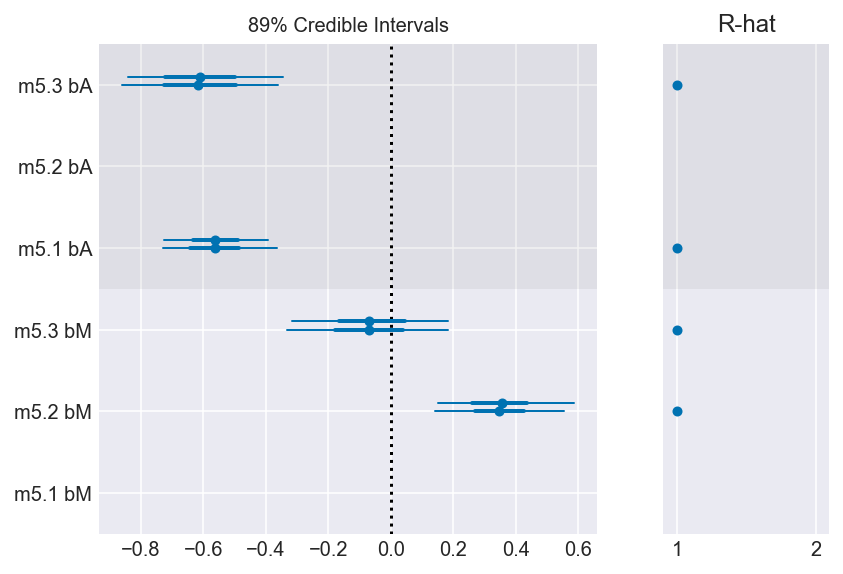

In [18]:
pm.forestplot([trace_5_3, trace_5_2, trace_5_1], models=["m5.3", "m5.2", "m5.1"], varnames=['bA', 'bM'], alpha=0.11);

##### Code 5.10

In [19]:
N = 50
age = stats.norm.rvs(size=N)
mar = stats.norm.rvs(size=N)
div = stats.norm.rvs(size=N)

# TODO: Fit the previous models with this data and see the similar results

### 5.1.4. Plotting multivariate posteriors

#### 5.1.4.1. Predictor residual plots

##### Code 5.11

In [20]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=0, sd=0.2)
    b = pm.Normal('b', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1210.47draws/s]


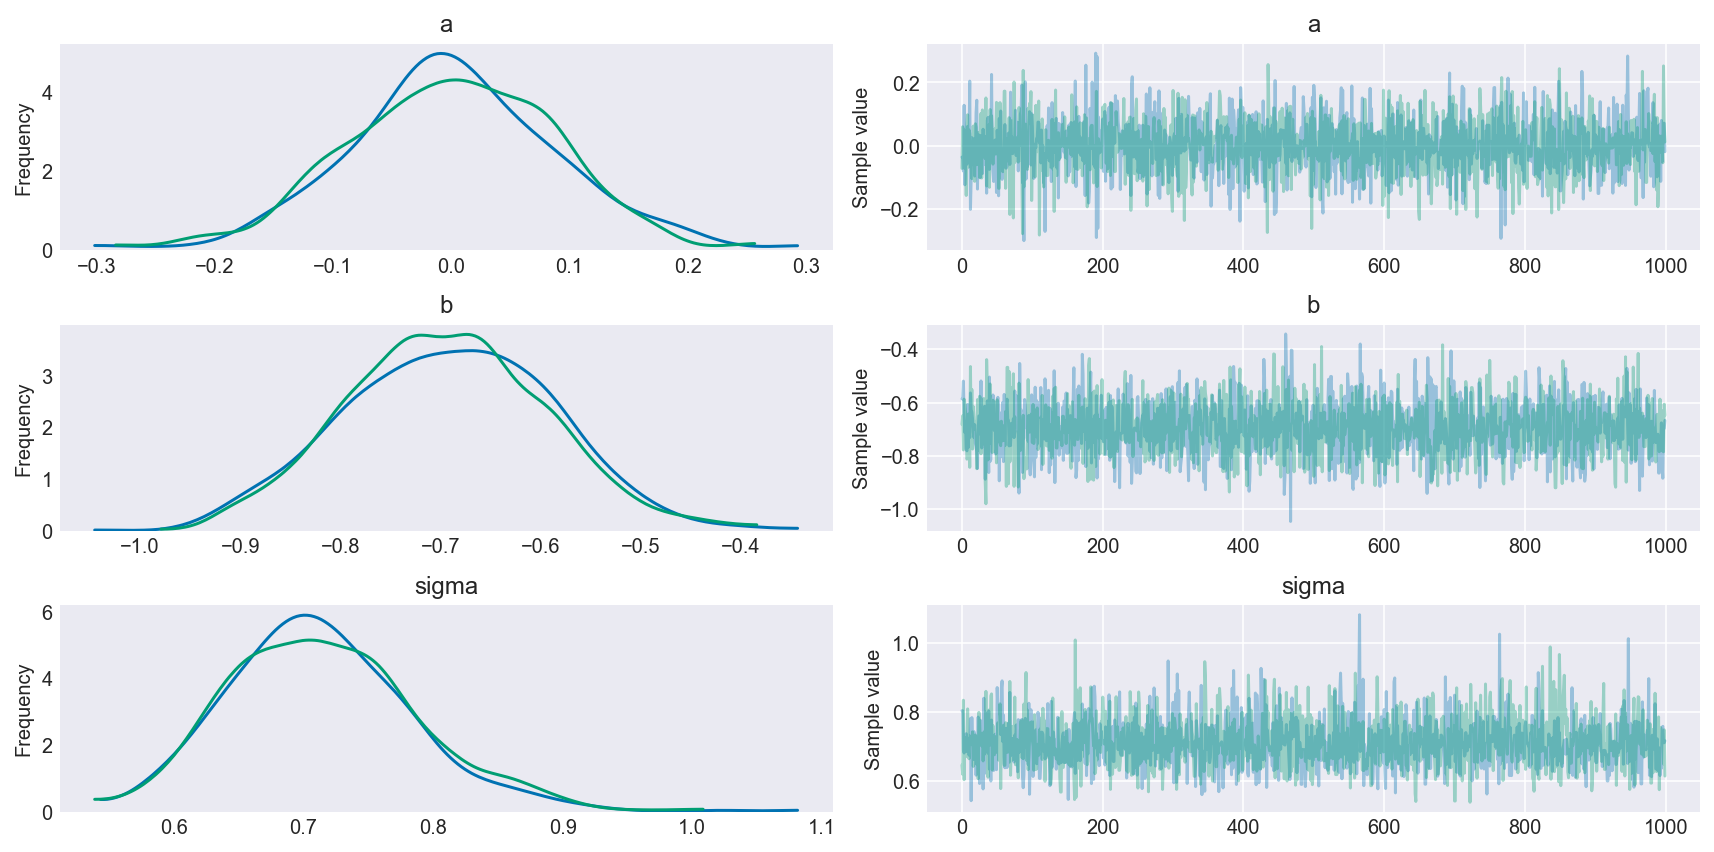

In [21]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

##### Code 5.12

In [22]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

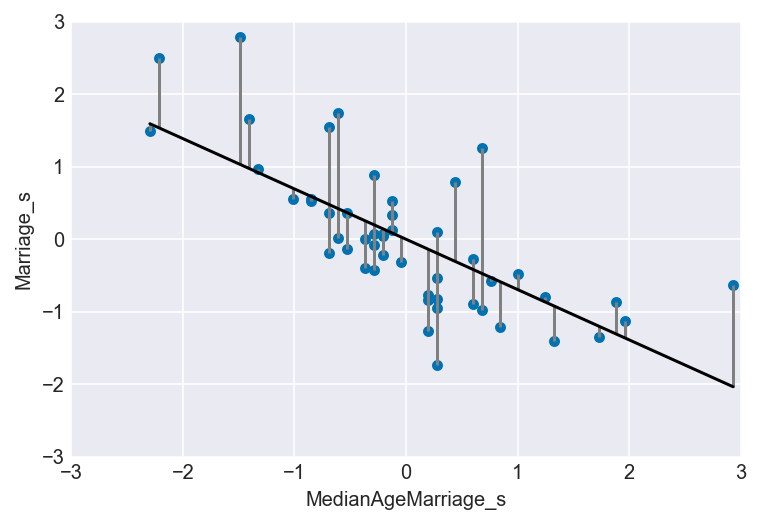

In [23]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

In [24]:
# TODO: Do all the plots in FIGURE 5.4

#### 5.1.4.2. Counterfactual plots

##### Code 5.13

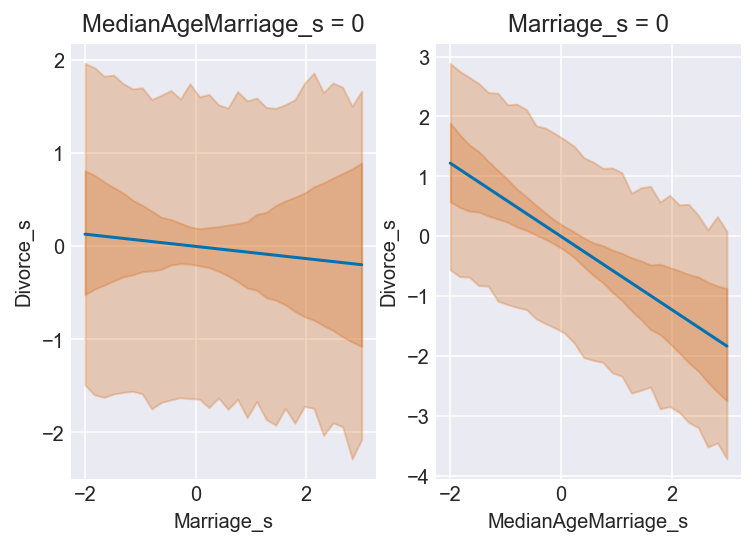

In [25]:
R_avg = np.linspace(-2, 3, 30)

mu_pred = trace_5_3['a'] + trace_5_3['bM'] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.subplot(1, 2, 1)
plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage_s')
plt.ylabel('Divorce_s')
plt.title('MedianAgeMarriage_s = 0');

mu_pred = trace_5_3['a'] + trace_5_3['bA'] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.subplot(1, 2, 2)
plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage_s')
plt.ylabel('Divorce_s')
plt.title('Marriage_s = 0');

#### 5.1.4.3. Posterior prediction plots

##### Code 5.14

In [26]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred, alpha=0.11)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred, alpha=0.11)

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 1000/1000 [00:00<00:00, 1259.18it/s]


##### Code 5.15

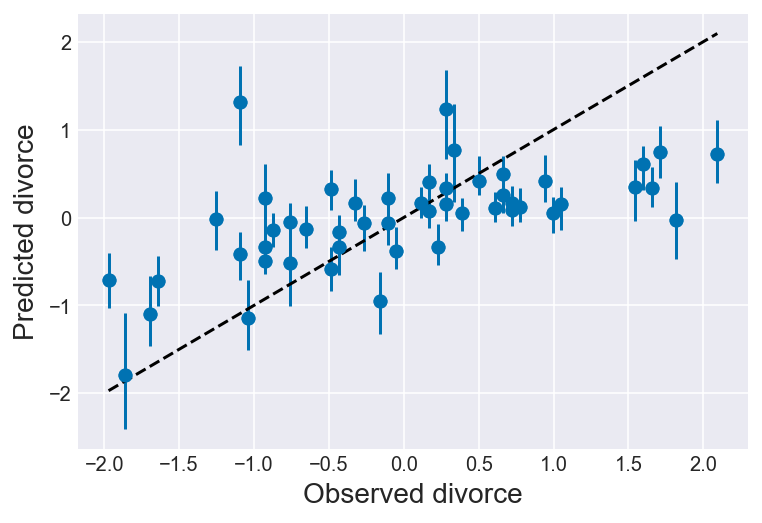

In [27]:
mu_hpd = pm.hpd(mu_pred, alpha=0.11)
plt.errorbar(d.Divorce_s, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce_s, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce_s.min(), d.Divorce_s.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

##### Code 5.16

In [28]:
# TODO: Investigate a way of identifying dots in a python plot similar to `identify` in the book

Extra code that doesn't appear in the book anymore

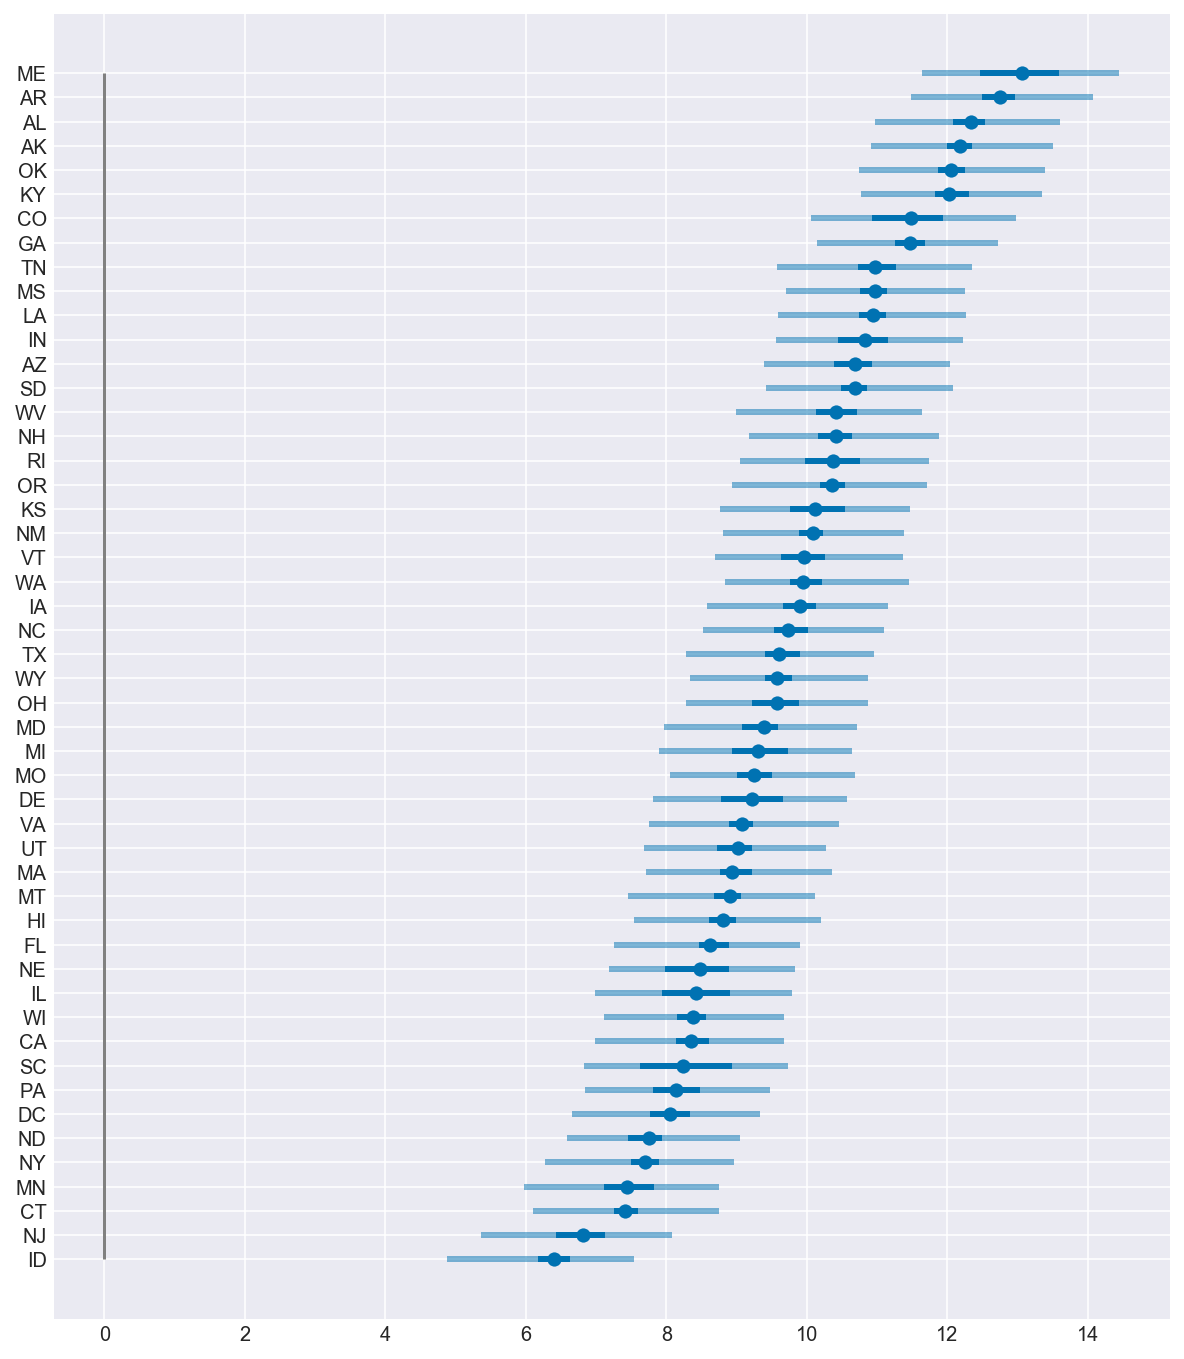

In [29]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

##### Code 5.x

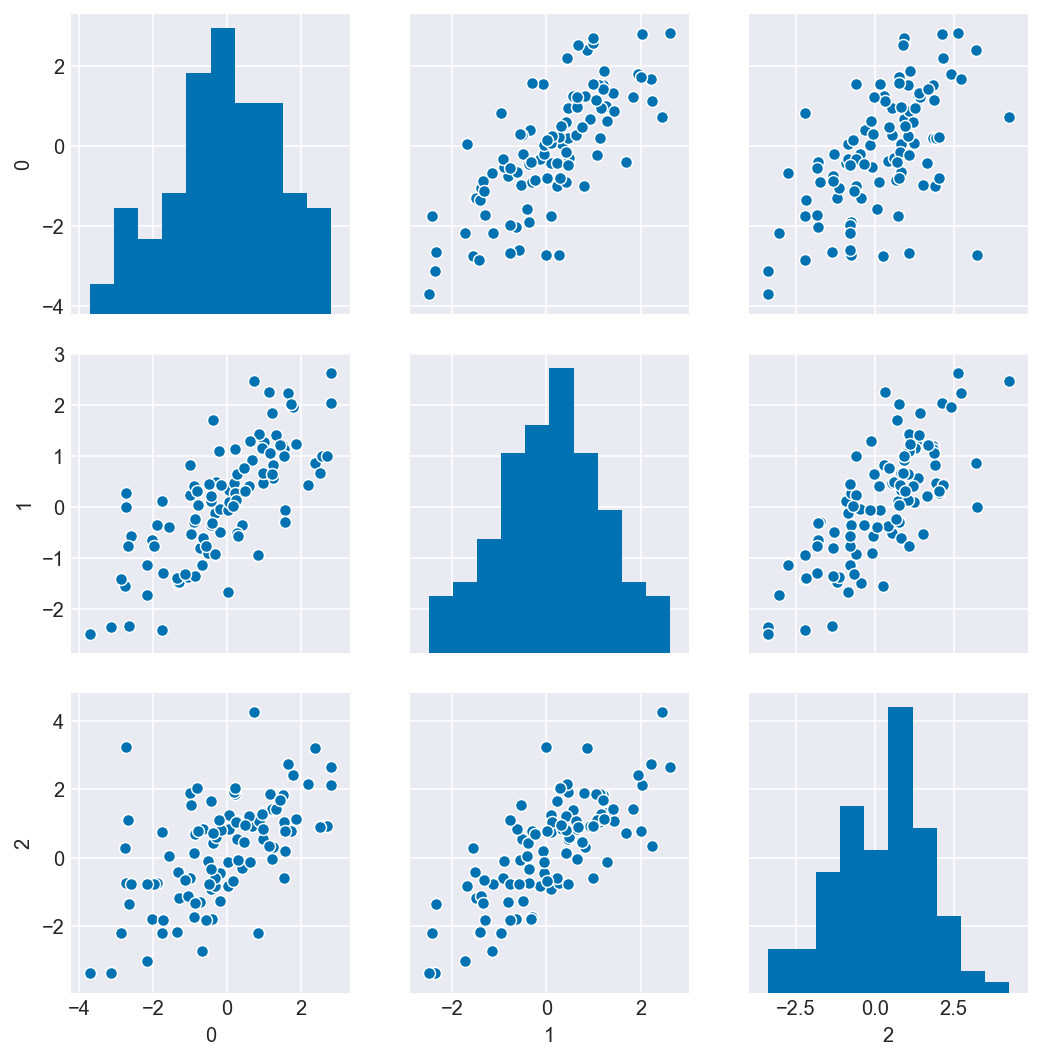

In [30]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

In [31]:
# TODO: do linear regression to detect the spurius correlation of x_spur and y

## 5.2. Masked relationship

##### Code 5.18

In [32]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  
0         67.98  1.95           55.16  
1         63.82  2.09             NaN  
2         69.04  2.51             NaN  
3         71.91  1.62             NaN  
4         53.22  2.19             NaN

In [33]:
d.shape

(29, 8)

##### Code 5.19

In [34]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(np.log(d["mass"]))

##### Code 5.20

In [35]:
#with pm.Model() as model_5_5_draft:
#    a = pm.Normal('a', mu=0, sd=1)
#    bn = pm.Normal('bn', mu=0, sd=1)
#    sigma = pm.Exponential('sigma', lam=1)
#    mu = pm.Deterministic('mu', a + bn * d["K"])
#    k = pm.Normal('k', mu=mu, sd=sigma, observed=d['K'])
#    trace_5_5_draft = pm.sample(1000, tune=1000)

The error is different from the book but it is still there.

##### Code 5.21

In [36]:
d["neocortex.perc"].head()

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
Name: neocortex.perc, dtype: float64

##### Code 5.22

In [37]:
dcc = d.dropna().copy()

In [38]:
dcc.head()

clade             species  kcal.per.g  perc.fat  perc.protein  \
0     Strepsirrhine      Eulemur fulvus        0.49     16.60         15.42   
5  New World Monkey  Alouatta seniculus        0.47     21.22         23.58   
6  New World Monkey          A palliata        0.56     29.66         23.46   
7  New World Monkey        Cebus apella        0.89     53.41         15.80   
9  New World Monkey          S sciureus        0.92     50.58         22.33   

   perc.lactose  mass  neocortex.perc         K         N         M  
0         67.98  1.95           55.16 -0.940041 -2.080196 -0.455836  
5         55.20  5.25           64.54 -1.063955 -0.508641  0.127441  
6         46.88  5.37           64.54 -0.506340 -0.508641  0.140751  
7         30.79  2.51           67.64  1.538249  0.010742 -0.307158  
9         27.09  0.68           68.85  1.724120  0.213470 -1.076270

In [39]:
dcc.shape

(17, 11)

##### Code 5.23

In [40]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=0, sd=1)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * dcc["N"])
    k = pm.Normal('k', mu=mu, sd=sigma, observed=dcc['K'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1314.78draws/s]


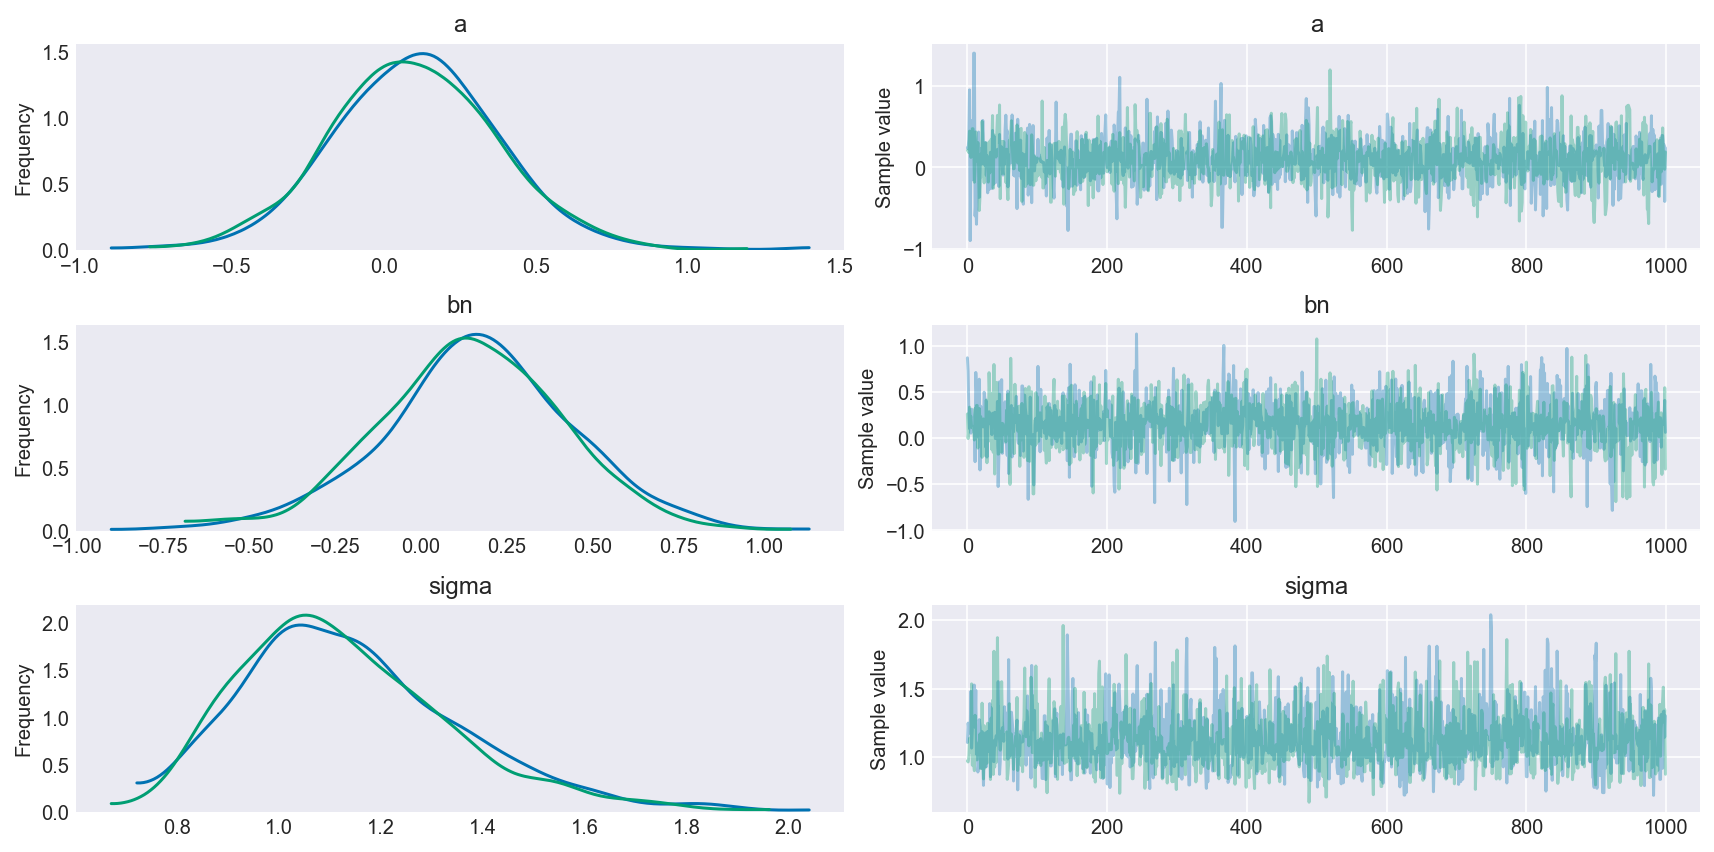

In [41]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

##### Code 5.24

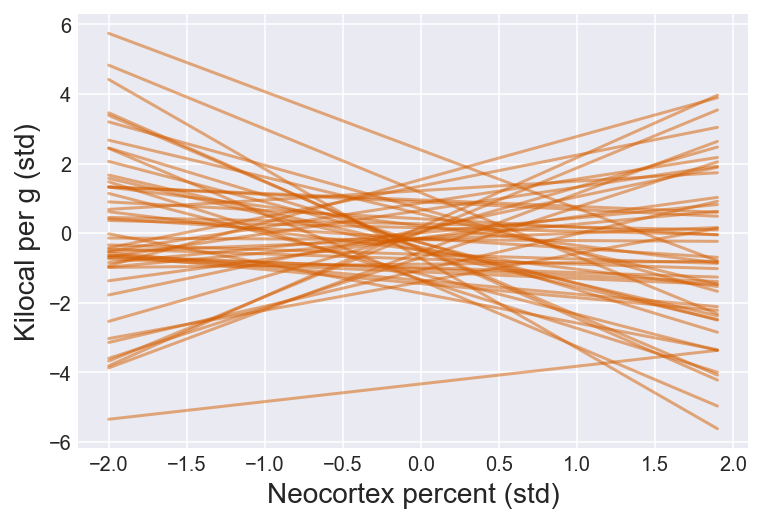

In [42]:
N = 50
a = stats.norm.rvs(loc=0, scale=1, size=N)
bn = stats.norm.rvs(loc=0, scale=1, size=N)

idx = np.arange(-2, 2, 0.1)

for (ai, bAi) in zip(a, bn):
    divorcePred = (ai + bAi * idx)
    plt.plot(idx, divorcePred , 'C2-', alpha=0.5)
plt.xlabel("Neocortex percent (std)", fontsize=14)
plt.ylabel("Kilocal per g (std)", fontsize=14);

##### Code 5.25

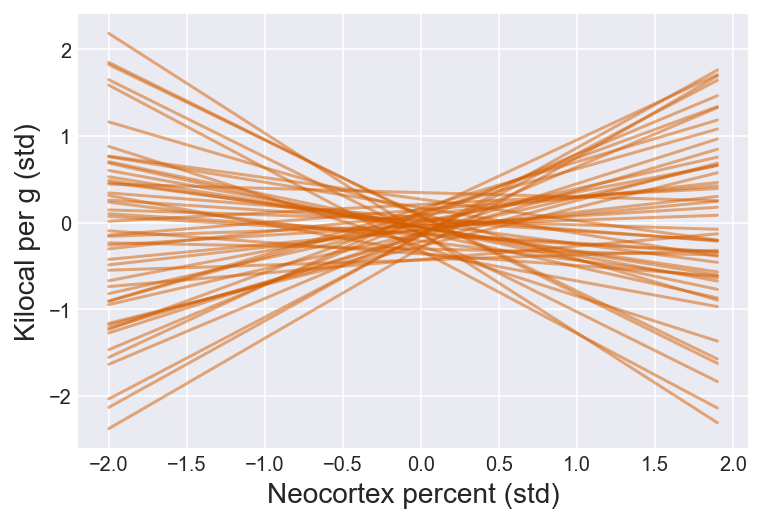

In [43]:
N = 50
a = stats.norm.rvs(loc=0, scale=0.2, size=N)
bn = stats.norm.rvs(loc=0, scale=0.5, size=N)

idx = np.arange(-2, 2, 0.1)

for (ai, bAi) in zip(a, bn):
    divorcePred = (ai + bAi * idx)
    plt.plot(idx, divorcePred , 'C2-', alpha=0.5)
plt.xlabel("Neocortex percent (std)", fontsize=14)
plt.ylabel("Kilocal per g (std)", fontsize=14);

In [44]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=0, sd=0.2)
    bn = pm.Normal('bn', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * dcc["N"])
    k = pm.Normal('k', mu=mu, sd=sigma, observed=dcc['K'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1301.48draws/s]


##### Code 5.26

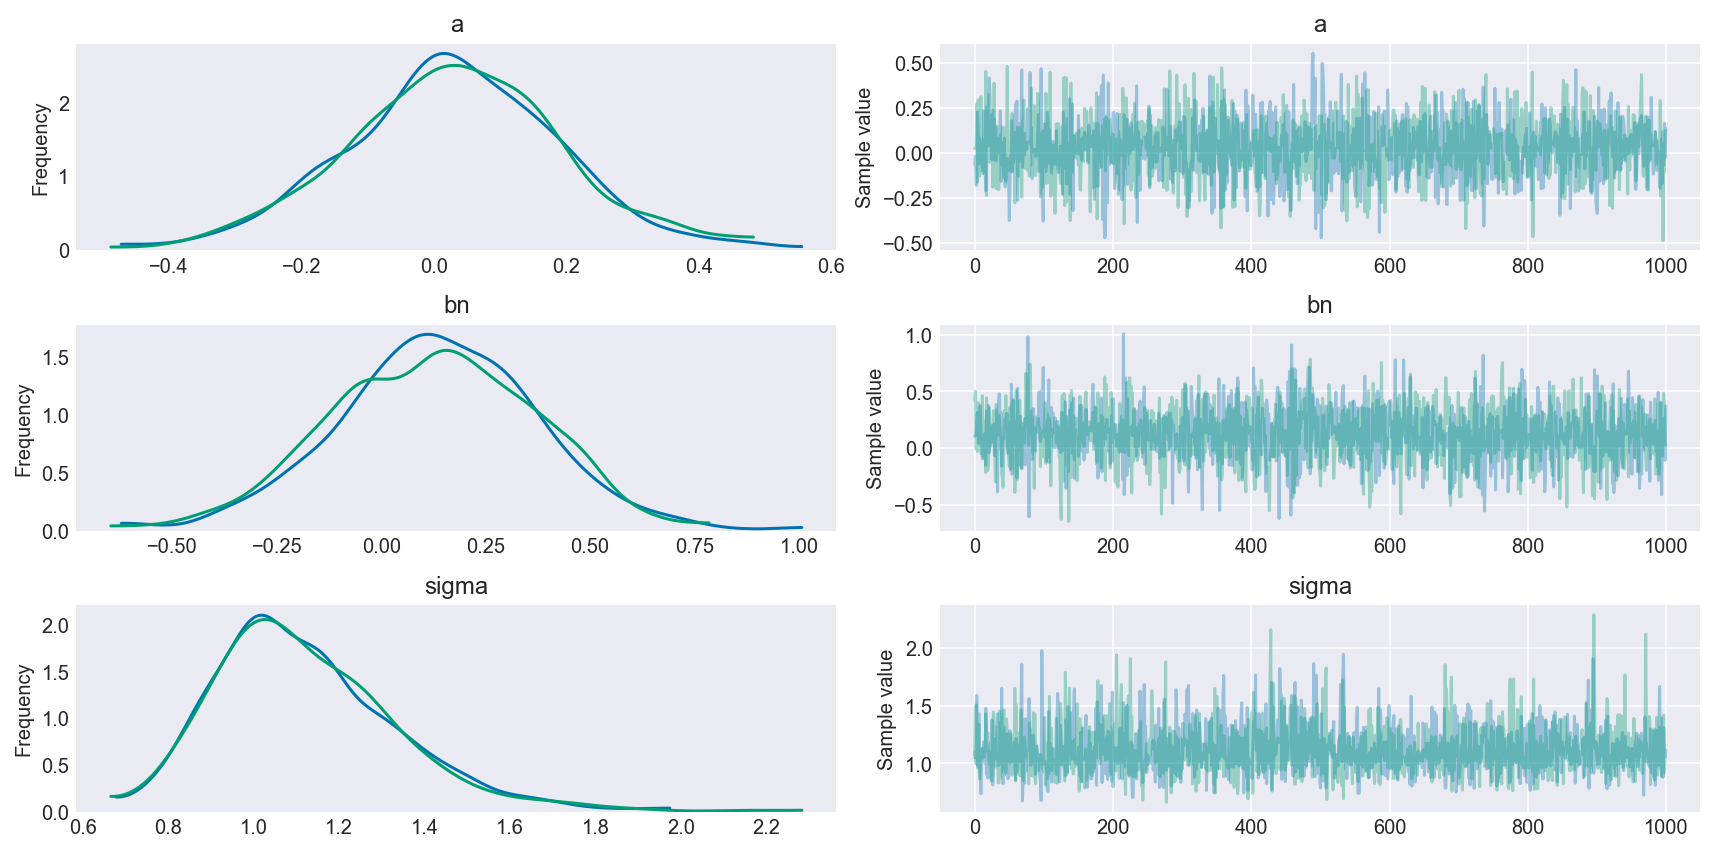

In [45]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

In [46]:
pm.summary(trace_5_5, varnames, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.03  0.16      0.00    -0.23      0.28  2115.64   1.0
bn     0.13  0.24      0.01    -0.24      0.51  1790.47   1.0
sigma  1.12  0.21      0.01     0.81      1.43  1735.57   1.0

##### Code 5.27

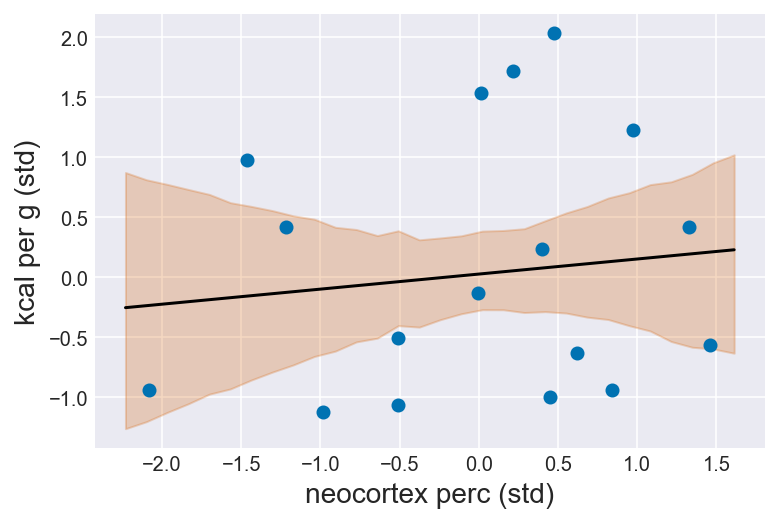

In [47]:
seq = np.linspace(dcc['N'].min()-0.15, dcc['N'].max()+0.15, 30)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['N'], d['K'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.fill_between(seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.24)

plt.xlabel('neocortex perc (std)', fontsize=14)
plt.ylabel('kcal per g (std)', fontsize=14);

##### Code 5.28

In [48]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bm', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * dcc['M'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['K'])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1390.92draws/s]


In [49]:
pm.summary(trace_5_6, ['a', 'bm', 'sigma'], alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.04  0.15       0.0    -0.20      0.29  2613.28   1.0
bm    -0.27  0.21       0.0    -0.61      0.06  2449.35   1.0
sigma  1.05  0.18       0.0     0.77      1.32  2182.26   1.0

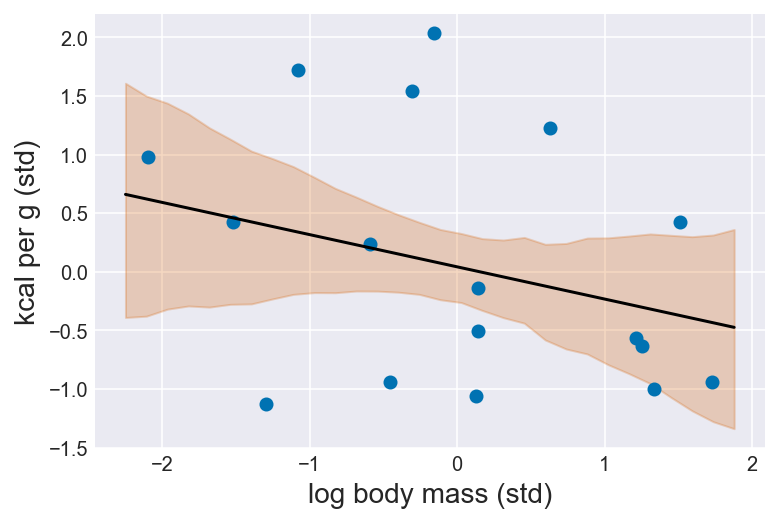

In [50]:
seq = np.linspace(dcc['M'].min()-0.15, dcc['M'].max()+0.15, 30)
mu_pred = trace_5_6['a'] + trace_5_6['bm'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(dcc['M'], dcc['K'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.fill_between(seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.24)

plt.xlabel('log body mass (std)', fontsize=14)
plt.ylabel('kcal per g (std)', fontsize=14);

##### Code 5.29

In [51]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=0, sd=0.2)
    bn = pm.Normal('bn', mu=0, sd=0.5)
    bm = pm.Normal('bm', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * dcc['N'] + bm * dcc['M'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['K'])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 938.58draws/s] 


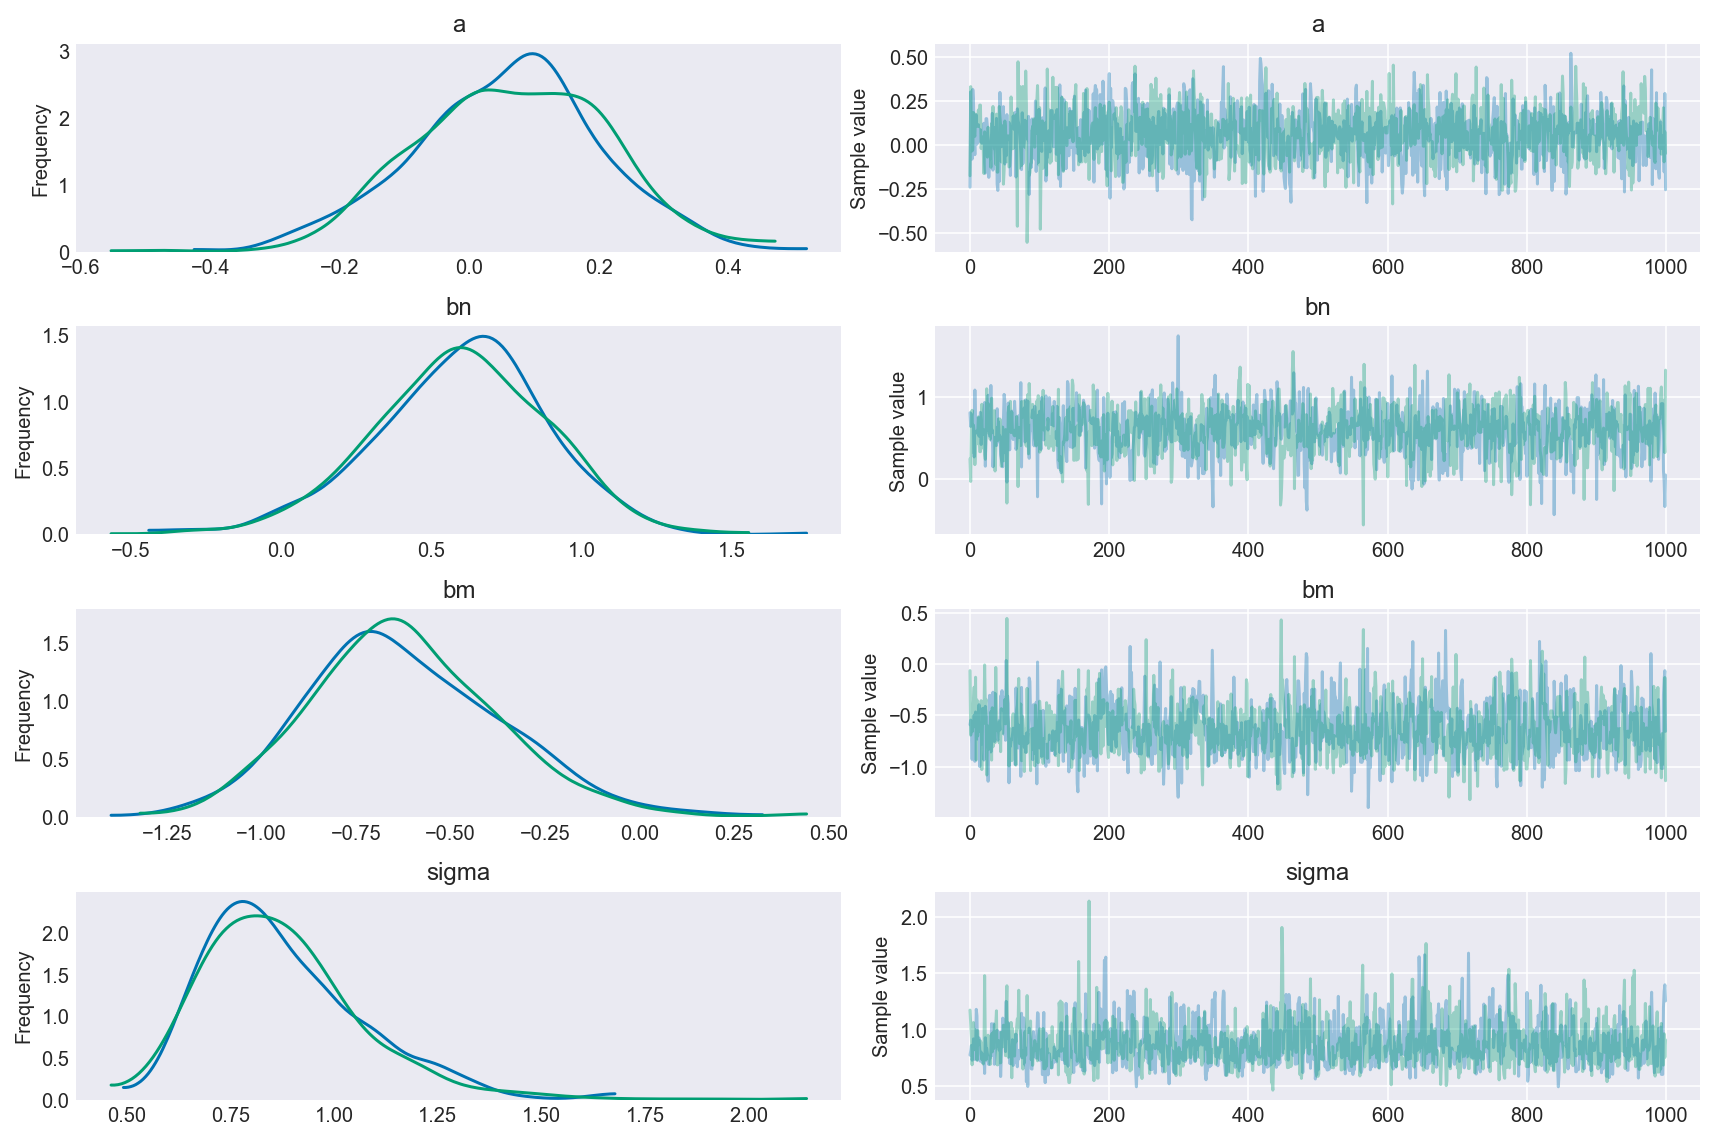

In [52]:
varnames = ['a', 'bn', 'bm', 'sigma']
pm.traceplot(trace_5_7, varnames);

In [53]:
pm.summary(trace_5_7, varnames, alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.06  0.14      0.00    -0.18      0.27  1627.53   1.0
bn     0.59  0.28      0.01     0.15      1.04  1245.87   1.0
bm    -0.63  0.25      0.01    -1.04     -0.25  1135.64   1.0
sigma  0.87  0.19      0.01     0.60      1.16  1058.61   1.0

##### Code 5.30

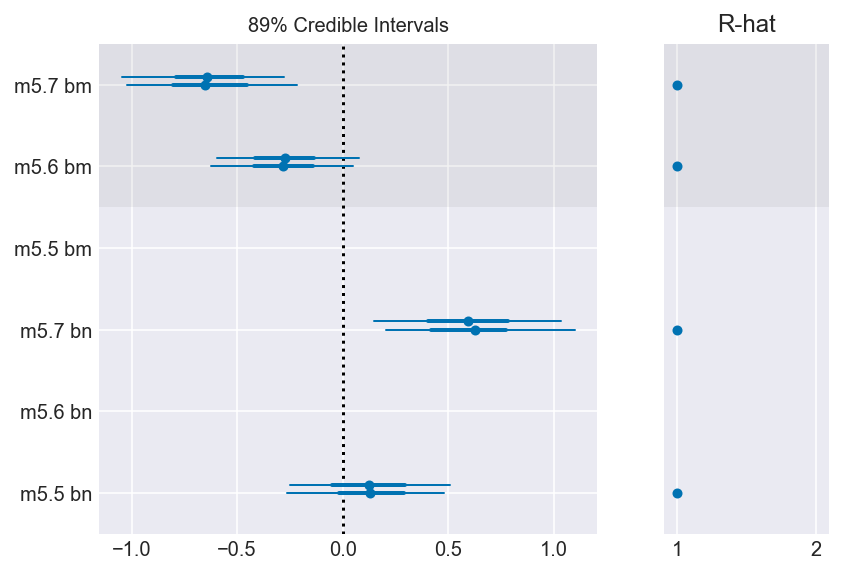

In [54]:
pm.forestplot([trace_5_7, trace_5_6, trace_5_5], models=["m5.7", "m5.6", "m5.5"], varnames=['bm', 'bn'], alpha=0.11);

##### Code 5.31

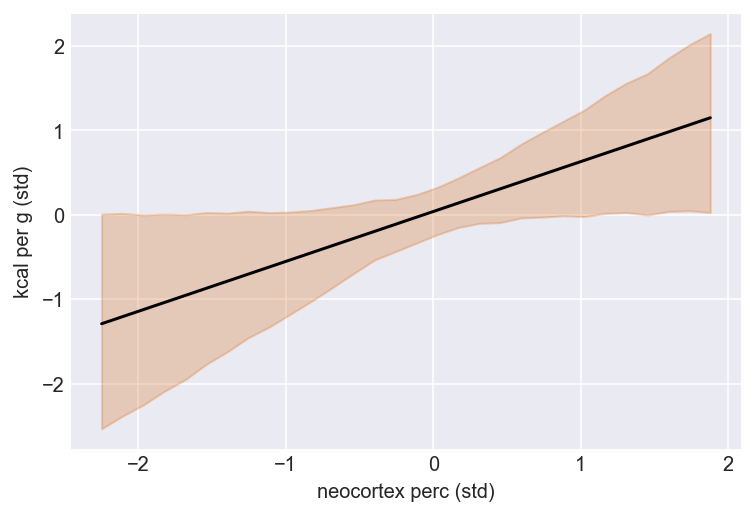

In [55]:
seq = np.linspace(dcc['M'].min()-0.15, dcc['M'].max()+0.15, 30)
mu_pred = trace_5_7['a'] + trace_5_7['bn'] * seq[:,None] + trace_5_7['bm'] * dcc['M'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.fill_between(seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.24)

plt.xlabel('neocortex perc (std)')
plt.ylabel('kcal per g (std)');

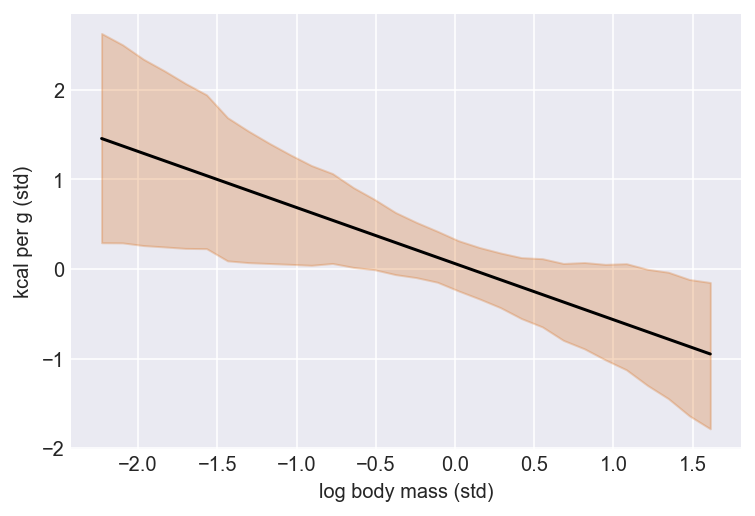

In [56]:
seq = np.linspace(dcc['N'].min()-0.15, dcc['N'].max()+0.15, 30)
mu_pred = trace_5_7['a'] + trace_5_7['bm'] * seq[:,None] + trace_5_7['bn'] * dcc['N'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.fill_between(seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.24)

plt.xlabel('log body mass (std)')
plt.ylabel('kcal per g (std)');

##### Code 5.32

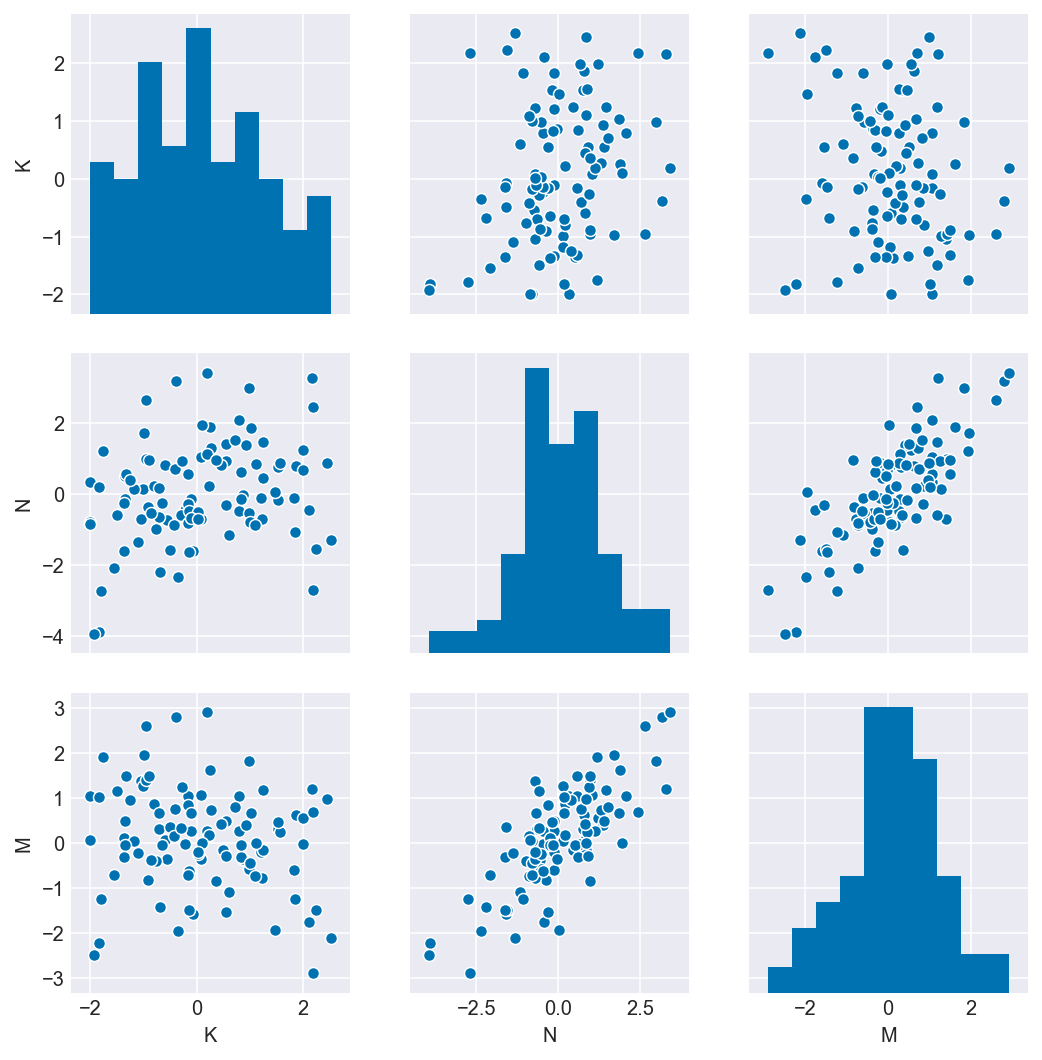

In [57]:
# M -> K <- N
# M -> N
N = 100
mass = stats.norm.rvs(size=N)
neoc = stats.norm.rvs(mass)
kcal = stats.norm.rvs(neoc - mass)
d_sim = pd.DataFrame([kcal, neoc, mass]).T
d_sim.columns = ["K", "N", "M"]
sns.pairplot(d_sim);

In [58]:
with pm.Model() as model_5_5_sim:
    a = pm.Normal('a', mu=0, sd=0.2)
    bn = pm.Normal('bn', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * d_sim["N"])
    k = pm.Normal('k', mu=mu, sd=sigma, observed=d_sim['K'])
    trace_5_5_sim = pm.sample(1000, tune=1000)
    
    
pm.summary(trace_5_5_sim, ['a', 'bn', 'sigma'], alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1271.43draws/s]


mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.05  0.10       0.0    -0.10      0.22  2846.59   1.0
bn     0.22  0.08       0.0     0.09      0.35  2678.76   1.0
sigma  1.16  0.08       0.0     1.02      1.28  3034.95   1.0

In [59]:
with pm.Model() as model_5_6_sim:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bm', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * d_sim['M'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d_sim['K'])
    trace_5_6_sim = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1093.12draws/s]


In [60]:
pm.summary(trace_5_6_sim, ['a', 'bm', 'sigma'], alpha=.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.07  0.10       0.0    -0.09      0.24  2583.79   1.0
bm    -0.18  0.10       0.0    -0.34     -0.02  2878.02   1.0
sigma  1.18  0.08       0.0     1.06      1.32  2422.10   1.0

In [61]:
with pm.Model() as model_5_7_sim:
    a = pm.Normal('a', mu=0, sd=0.2)
    bn = pm.Normal('bn', mu=0, sd=0.5)
    bm = pm.Normal('bm', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * d_sim['N'] + bm * d_sim['M'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d_sim['K'])
    trace_5_7_sim = pm.sample(1000, tune=1000)
    
pm.summary(trace_5_7_sim, ['a', 'bm', 'bn', 'sigma'], alpha=.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 619.94draws/s]


mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
a      0.11  0.09       0.0    -0.03      0.25  1729.35   1.0
bm    -0.92  0.12       0.0    -1.11     -0.71  1524.49   1.0
bn     0.78  0.10       0.0     0.62      0.93  1365.02   1.0
sigma  0.92  0.07       0.0     0.81      1.02  1824.66   1.0

##### Code 5.33

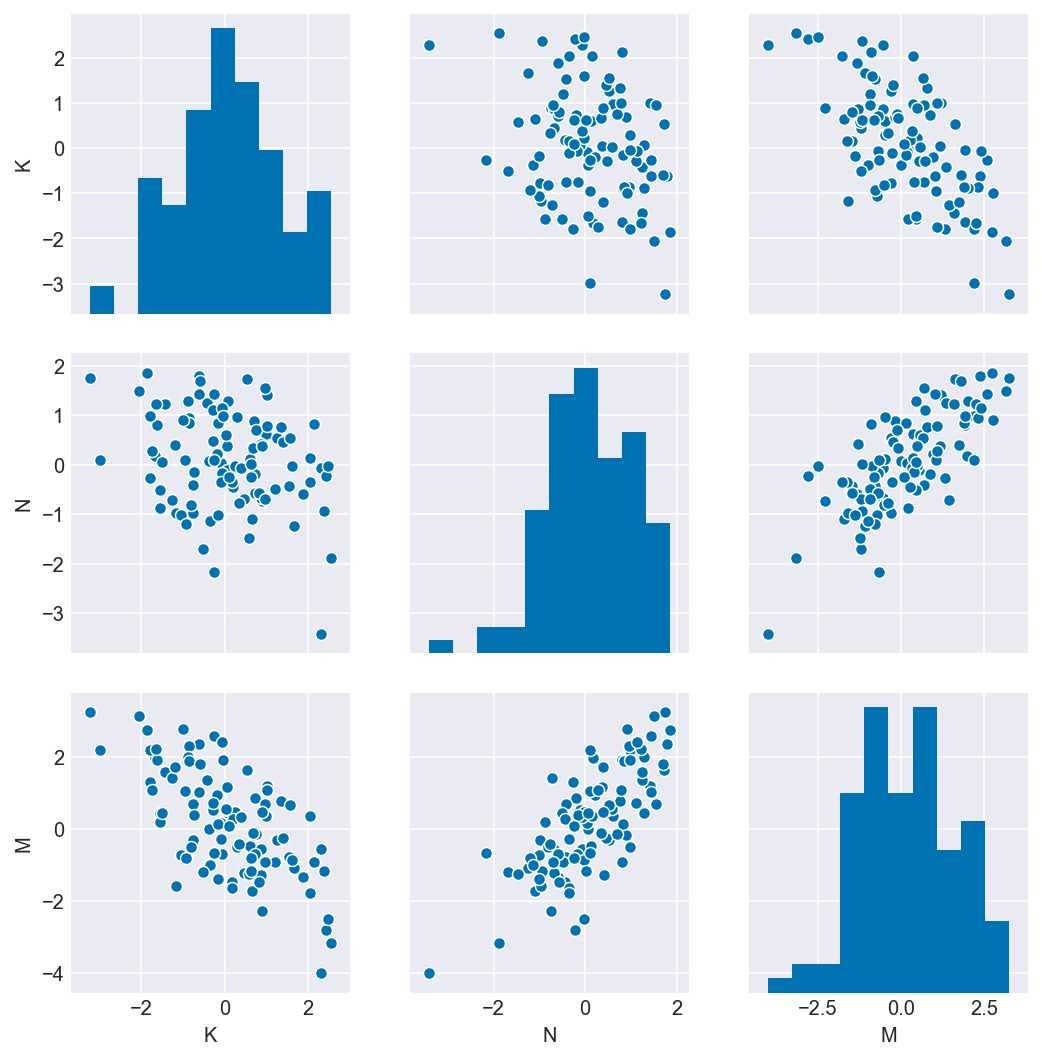

In [62]:
# M -> K <- N
# N -> M
N = 100
neoc = stats.norm.rvs(size=N)
mass = stats.norm.rvs(neoc)
kcal = stats.norm.rvs(neoc - mass)
d_sim2 = pd.DataFrame([kcal, neoc, mass]).T
d_sim2.columns = ["K", "N", "M"]
sns.pairplot(d_sim2);

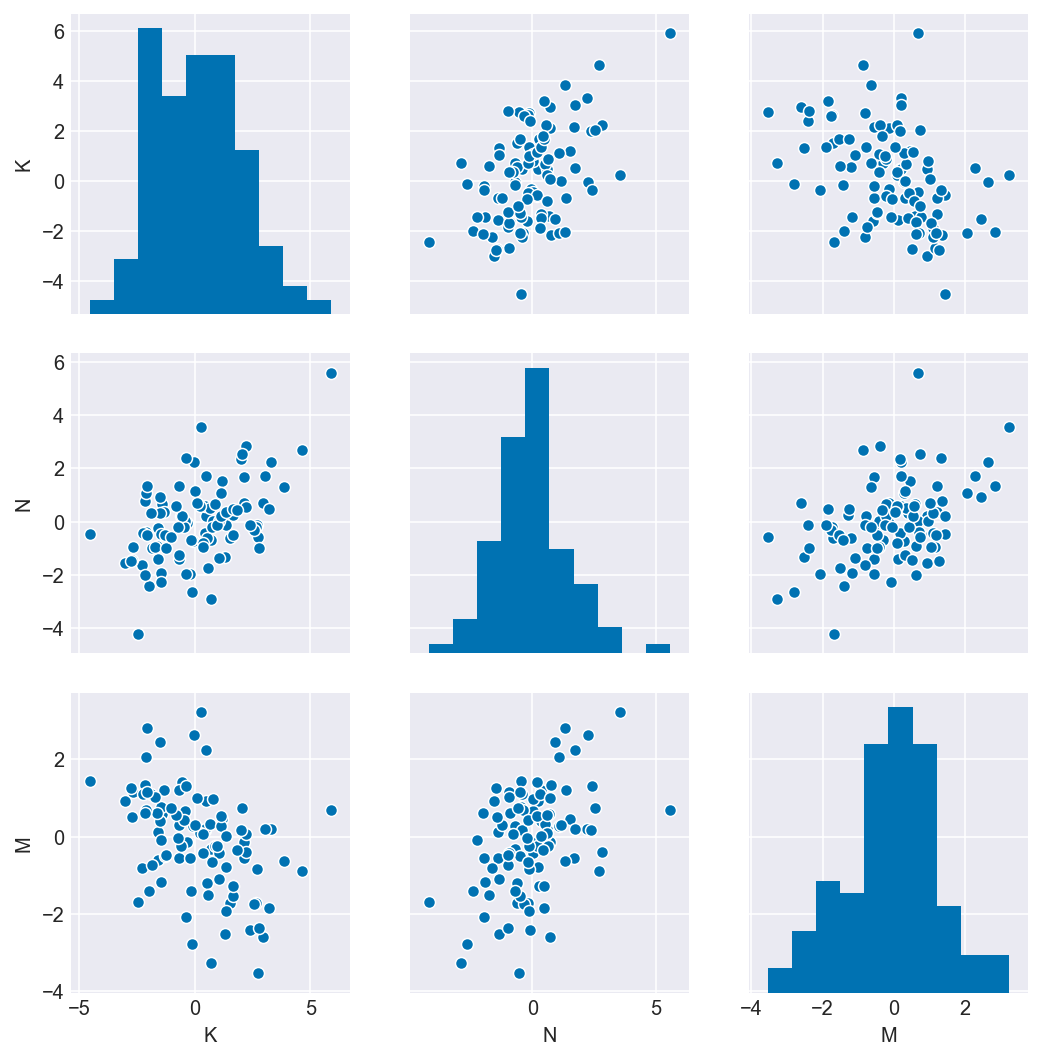

In [63]:
# M -> K <- N
# M <- U -> N
N = 100
u = stats.norm.rvs(size=N)
mass = stats.norm.rvs(u)
neoc = stats.norm.rvs(u)
kcal = stats.norm.rvs(neoc - mass)
d_sim3 = pd.DataFrame([kcal, neoc, mass]).T
d_sim3.columns = ["K", "N", "M"]
sns.pairplot(d_sim3);

## 5.3 Categorical variables

### 5.3.1 Binary categories

##### Code 5.34

In [64]:
d = pd.read_csv("Data/Howell1.csv", sep=";")

In [65]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

##### Code 5.35

In [66]:
N = int(1e4)
mu_female = stats.norm.rvs(loc=178, scale=20, size=N)
mu_male = stats.norm.rvs(loc=178, scale=20, size=N) + stats.norm.rvs(loc=0, scale=10, size=N)
pd.DataFrame(np.array([mu_female, mu_male]).T, columns=["mu_female", "mu_male"]).describe(percentiles=[0.055, 0.945]).T.round(2)

count    mean    std    min    5.5%     50%   94.5%     max
mu_female  10000.0  177.91  20.02  94.05  146.21  177.84  210.42  249.37
mu_male    10000.0  177.98  22.21  82.62  142.67  178.33  213.13  265.34

##### Code 5.36

In [67]:
d["female"] = 1 - d["male"] 

In [68]:
d.head()

height     weight   age  male  female
0  151.765  47.825606  63.0     1       0
1  139.700  36.485807  63.0     0       1
2  136.525  31.864838  65.0     0       1
3  156.845  53.041915  41.0     1       0
4  145.415  41.276872  51.0     0       1

##### Code 5.37

In [69]:
with pm.Model() as model_5_8:
    af = pm.Normal('af', mu=178, sd=20)
    am = pm.Normal('am', mu=178, sd=20)
    mu = pm.Deterministic('mu', af * d['female'] + am * d['male'])
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d['height'])
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, am, af]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 865.03draws/s] 


In [70]:
pm.summary(trace_5_8, ['af', 'am', 'sigma'], alpha=0.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
af     134.95  1.58      0.03   132.46    137.48  2682.49   1.0
am     142.56  1.74      0.03   139.80    145.30  2893.67   1.0
sigma   27.39  0.84      0.02    26.10     28.76  2838.85   1.0

##### Code 5.38

In [71]:
trace_5_8.add_values({'diff_fm':trace_5_8['af'] - trace_5_8['am']})
pm.summary(trace_5_8, ['af', 'am', 'diff_fm', 'sigma'], alpha=0.11).round(2)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
af       134.95  1.58      0.03   132.46    137.48  2682.49   1.0
am       142.56  1.74      0.03   139.80    145.30  2893.67   1.0
diff_fm   -7.61  2.37      0.05   -11.32     -3.81  2743.04   1.0
sigma     27.39  0.84      0.02    26.10     28.76  2838.85   1.0

### 5.3.2 Many categories

In [72]:
d = pd.read_csv('Data/milk.csv', sep=';')
d["clade"].unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

In [73]:
d["clade_id"] = pd.factorize(d["clade"])[0]

In [74]:
d.head()

clade         species  kcal.per.g  perc.fat  perc.protein  \
0  Strepsirrhine  Eulemur fulvus        0.49     16.60         15.42   
1  Strepsirrhine        E macaco        0.51     19.27         16.91   
2  Strepsirrhine        E mongoz        0.46     14.11         16.85   
3  Strepsirrhine   E rubriventer        0.48     14.91         13.18   
4  Strepsirrhine     Lemur catta        0.60     27.28         19.50   

   perc.lactose  mass  neocortex.perc  clade_id  
0         67.98  1.95           55.16         0  
1         63.82  2.09             NaN         0  
2         69.04  2.51             NaN         0  
3         71.91  1.62             NaN         0  
4         53.22  2.19             NaN         0

##### Code 5.41

In [75]:
d["K"] = standardize(d["kcal.per.g"])

In [76]:
with pm.Model() as model_5_9:
    a = pm.Normal('a', mu=0, sd=0.5, shape=4)
    mu = pm.Deterministic('mu', a[d["clade_id"]])
    sigma= pm.Exponential('sigma', lam=1)
    k = pm.Normal('k', mu=mu, sd=sigma, observed=d["K"])
    trace_5_9 = pm.sample(1000, tune=1000)

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]
Sampling 2 chains: 100%|██████████| 4000/4

In [77]:
clade_type = pd.factorize(d["clade"])[1]

In [78]:
for x in enumerate(clade_type):
    print(x)

(0, 'Strepsirrhine')
(1, 'New World Monkey')
(2, 'Old World Monkey')
(3, 'Ape')


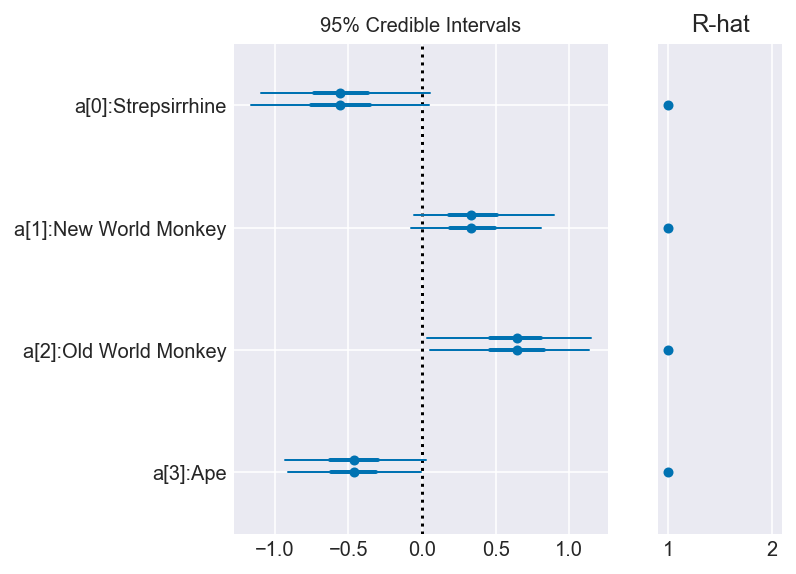

In [79]:
labels = ["a[{0}]:{1}".format(idx, cl) for (idx, cl) in enumerate(clade_type)]
pm.forestplot(trace_5_9, varnames=["a"], ylabels=labels);

##### Code 5.42

In [80]:
d["house"] = stats.randint.rvs(0, 4, size=len(d))

##### Code 5.43

In [81]:
with pm.Model() as model_5_10:
    a = pm.Normal('a', mu=0, sd=0.5, shape=4)
    h = pm.Normal('h', mu=0, sd=0.5, shape=4)
    mu = pm.Deterministic('mu', a[d["clade_id"]] + h[d["house"]])
    sigma = pm.Exponential('sigma', lam=1)
    k = pm.Normal('k', mu=mu, sd=sigma, observed=d["K"])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, h, a]
/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|██████████| 400

In [82]:
labels

['a[0]:Strepsirrhine',
 'a[1]:New World Monkey',
 'a[2]:Old World Monkey',
 'a[3]:Ape']

In [83]:
houselabels = ["h[{0}]:{1}".format(idx, h) for (idx, h) in enumerate("Gryffindor,Hufflepuff,Ravenclaw,Slytherin".split(","))]

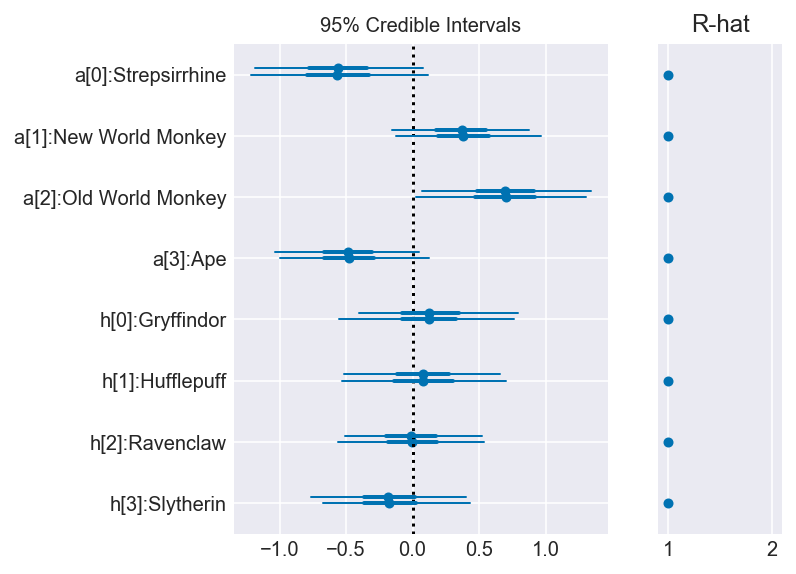

In [84]:
pm.forestplot(trace_5_10, varnames=["a", "h"], ylabels=labels+houselabels);

## 5.5 Practice

Some day I might include the exercises

In [93]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.15.4
Pandas 0.24.1
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0



/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  


## OLD CODE

#### Code 5.29

In [85]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [86]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains:  76%|███████▌  | 3029/4000 [02:33<00:49, 19.71draws/s]


mean     sd  mc_error  hpd_5.5  hpd_94.5    n_eff   Rhat
a      5.720  0.548     0.025    4.909     6.629  520.548  1.000
bl     1.179  4.648     0.263   -5.994     8.377  277.457  1.006
br    -0.478  4.656     0.264   -7.639     6.729  277.457  1.006
sigma  1.545  0.114     0.005    1.355     1.707  547.514  1.005

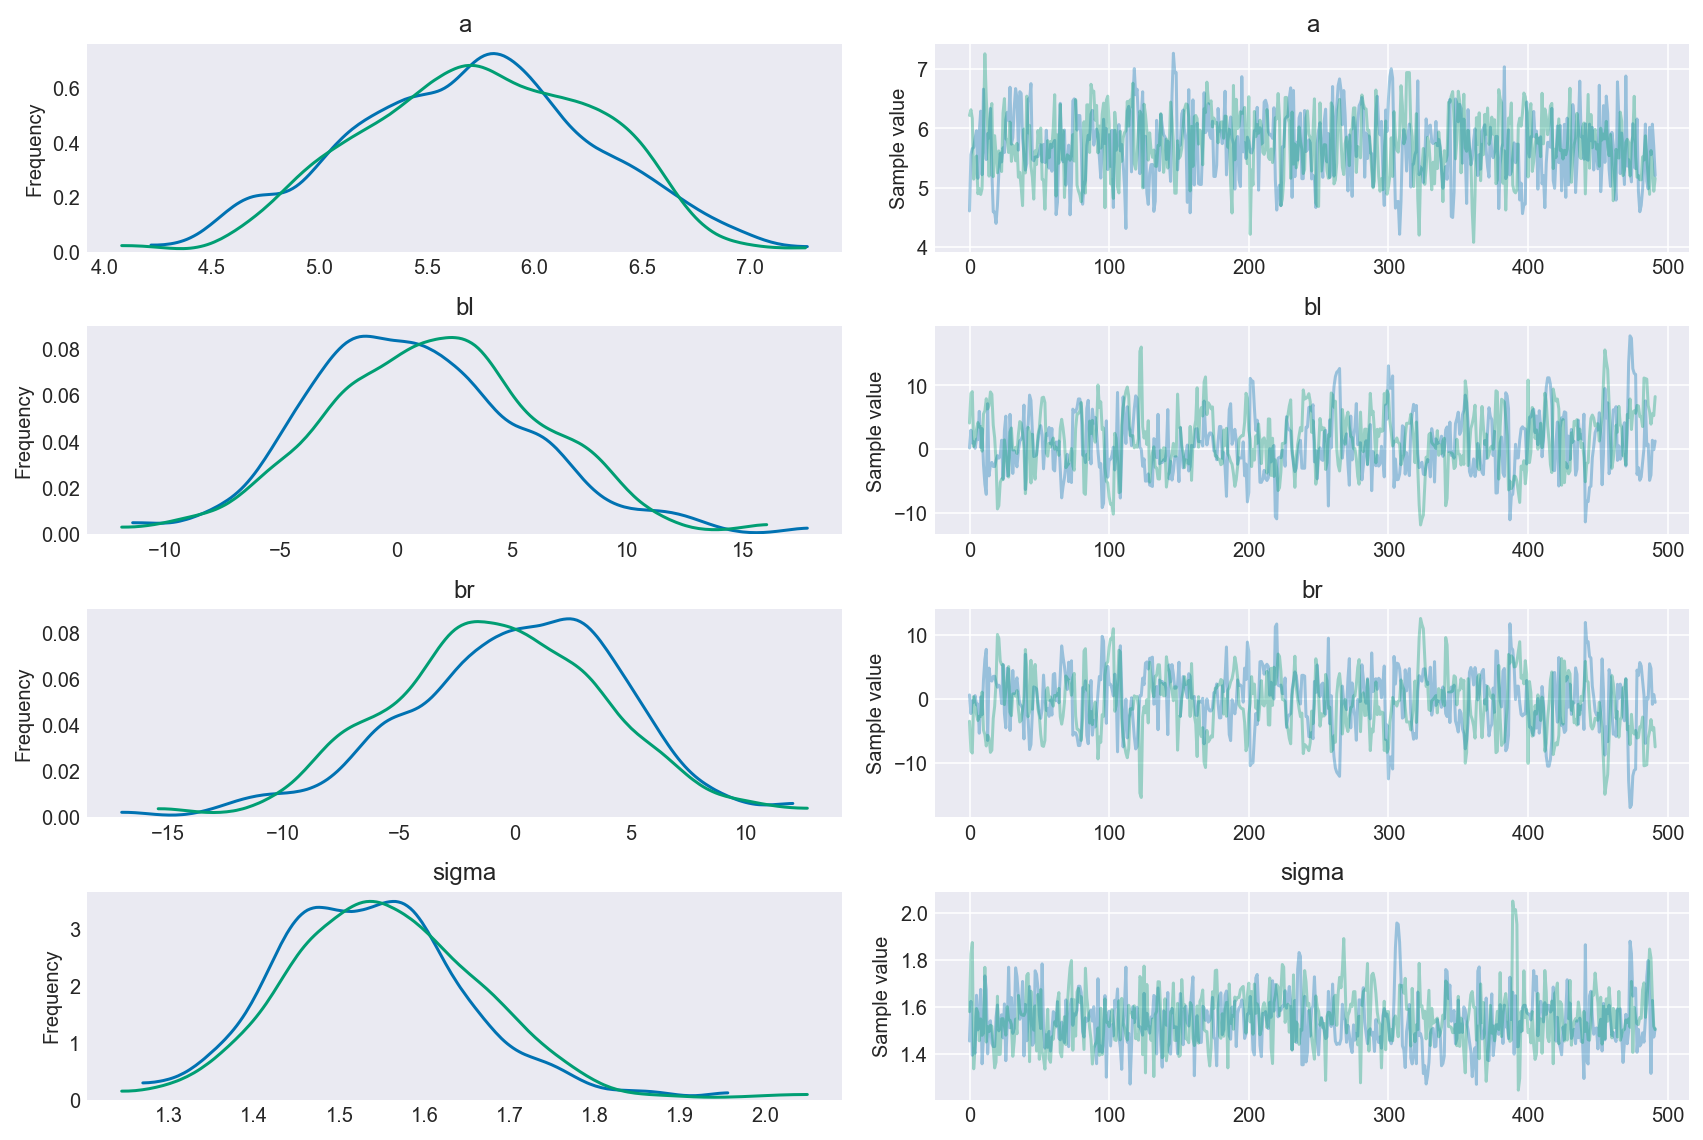

In [87]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

#### Code 5.31

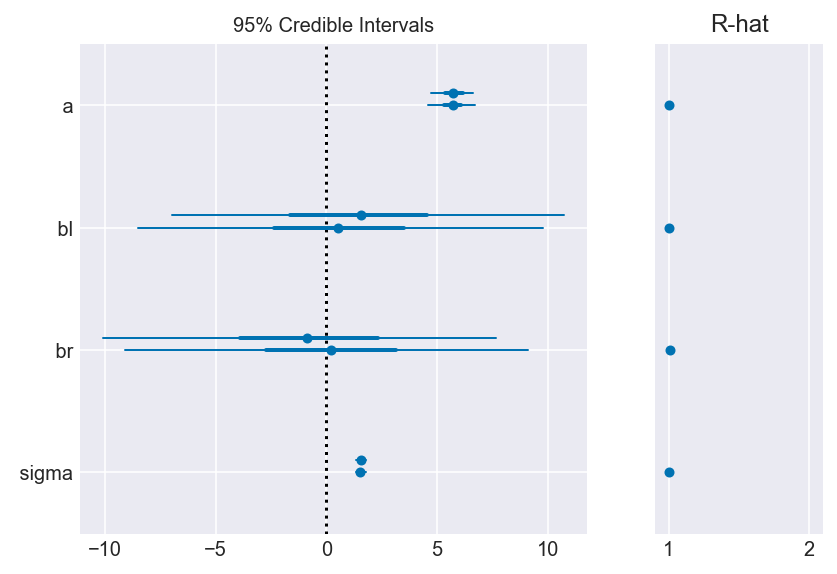

In [88]:
pm.forestplot(trace_5_8, varnames=varnames);

#### Code 5.32

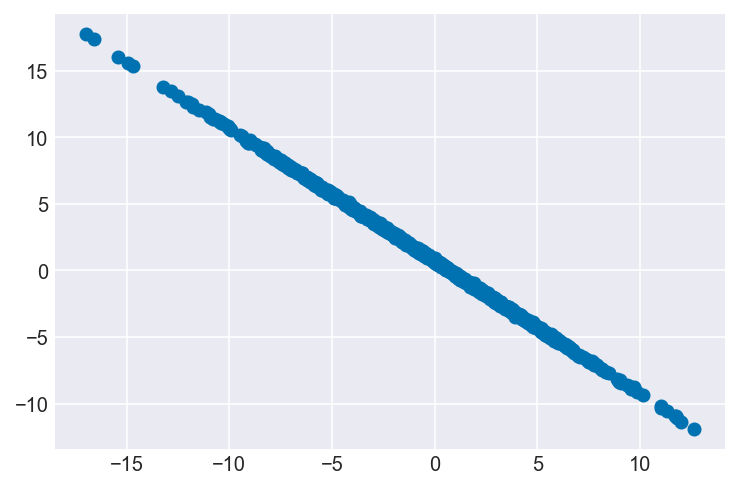

In [89]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

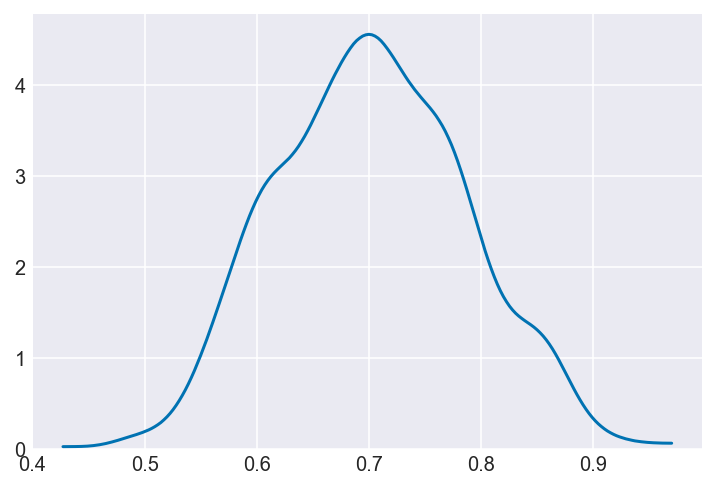

In [90]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

#### Code 5.34

In [91]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains:  33%|███▎      | 1314/4000 [00:02<00:05, 513.32draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
varnames_1 = ['a', 'bl', 'sigma']
#pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

#### Code 5.35

In [ ]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

#### Code 5.36

In [ ]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['a', 'bf', 'sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

In [ ]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

#### Code 5.37

In [ ]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

#### Code 5.38

In [ ]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [ ]:
milk.corr()['perc.fat']['perc.lactose']

#### Code 5.40

In [ ]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 5.41

In [ ]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

#### Code 5.42

In [ ]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000, tune=1000) 

In [ ]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

#### Code 5.43

In [ ]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000) 

In [ ]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

#### Code 5.44

In [ ]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

#### Code 5.45

In [ ]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000, tune=1000) 

In [ ]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

#### Code 5.46

In [ ]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

#### Code 5.47

In [ ]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000) 

#### Code 5.48

In [ ]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [ ]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

#### Code 5.50

In [ ]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

#### Code 5.51

In [ ]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])
    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

#### Code 5.52

In [ ]:
varnames = ['mu_ape', 'mu_NWM', 'b_OWM', 'b_S']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]

#### Code 5.53

In [ ]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

#### Code 5.54

In [ ]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [ ]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = a[d['clade_id'].values], sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000) 

In [ ]:
varnames = ['a', 'sigma']
pm.summary(trace_5_16_alt, varnames, alpha=.11)

The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [ ]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)